# Time Series Feature Extraction Library

GitHub - https://github.com/fraunhoferportugal/tsfel

Docs - https://tsfel.readthedocs.io/en/latest/

In [1]:
import sys
sys.path.append('ts_fe/')
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tsfel

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interpolate
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
from src.utils import *

In [4]:
DATA_FOLDER = 'ts_fe/data/raw/UCI_HAR/'
INPUT_FOLDER_TRAIN = DATA_FOLDER + 'train/InertialSignals/'
INPUT_FOLDER_TEST = DATA_FOLDER + 'test/InertialSignals/'
LABELFILE_TRAIN = DATA_FOLDER + 'train/y_train.txt'
LABELFILE_TEST = DATA_FOLDER + 'test/y_test.txt'

train_signals, test_signals, train_labels, test_labels = read_data(
    input_folder_train=INPUT_FOLDER_TRAIN,
    input_folder_test=INPUT_FOLDER_TEST,
    labelfile_train=LABELFILE_TRAIN,
    labelfile_test=LABELFILE_TEST
)

train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

In [5]:
# dataset sampling frequency
fs = 100

In [6]:
cfg_file = tsfel.get_features_by_domain('temporal')

In [7]:
train_signals.shape

(7352, 128, 9)

In [9]:
Y_train = np.array(train_labels)
Y_test = np.array(test_labels)

In [11]:
EXTRACT = True

if EXTRACT:
    X_train = tsfel.time_series_features_extractor(cfg_file, train_signals, fs=fs)
    X_test = tsfel.time_series_features_extractor(cfg_file, test_signals, fs=fs)
    X_train.to_csv('../data/processed/X_train_tsfel.csv')
    X_test.to_csv('../data/processed/X_test_tsfel.csv')
    pd.DataFrame(Y_train).to_csv('../data/processed/Y_train_tsfel.csv')
    pd.DataFrame(Y_test).to_csv('../data/processed/Y_test_tsfel.csv')
else:
    X_train = pd.read_csv('../data/processed/X_train_tsfel.csv', index_col=0)
    X_test = pd.read_csv('../data/processed/X_test_tsfel.csv', index_col=0)
    Y_train = pd.read_csv('../data/processed/Y_train_tsfel.csv', index_col=0, header=None)
    Y_test = pd.read_csv('../data/processed/Y_test_tsfel.csv', index_col=0, header=None)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [12]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

In [13]:
X_train.shape, X_test.shape

((7352, 87), (2947, 87))

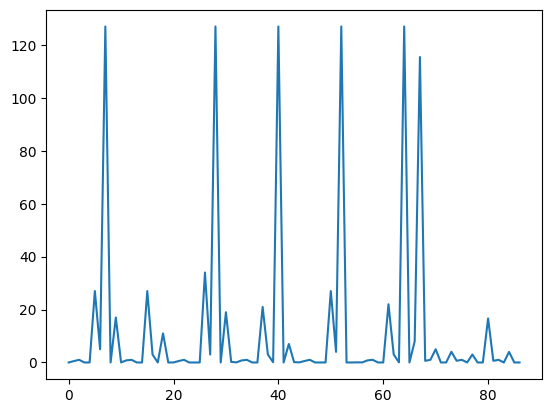

In [14]:
plt.plot(X_train[0])

In [15]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

Accuracy on training set is : 1.0
Accuracy on test set is : 0.9158466236851035
              precision    recall  f1-score   support

           1       0.92      0.93      0.92       496
           2       0.88      0.97      0.92       471
           3       0.93      0.81      0.87       420
           4       0.91      0.84      0.88       491
           5       0.86      0.92      0.89       532
           6       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.91      0.91      2947
weighted avg       0.92      0.92      0.92      2947



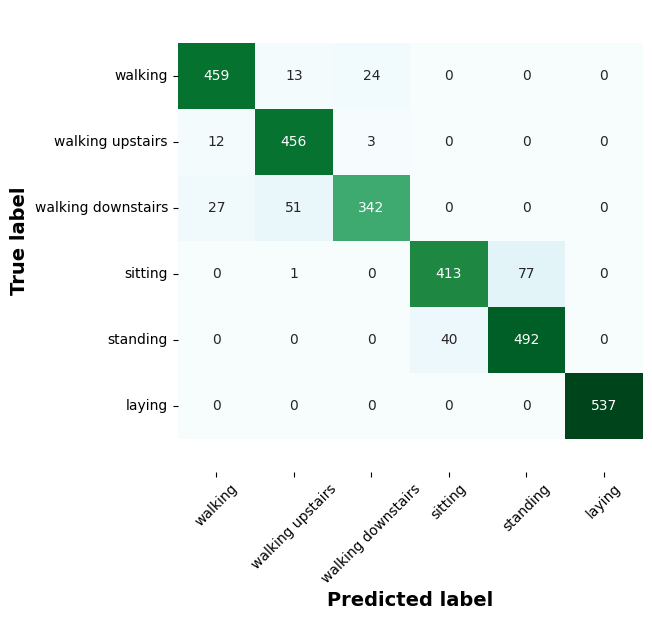

In [16]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',\
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}   
plot_confusion(Y_test, Y_test_pred, activities_description.values())